In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

# Validate endogenous volumes against those from VP2030

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
sm = stepmodel.read_json(model_path + 'de_zones')

In [6]:
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in segments][::2]

In [7]:
# Load old volumes
volumes_file = 'de_volumes_exo'
v = stepmodel.read_zippedpickles(model_path + volumes_file)
# Rename columns from VP2030 to match the model's demand segments
car_segment_dict = {'0': '_no_car', '1': '_car'}
vp_purpose_dict = {'Fz1': 'commuting', 'Fz2': 'education', 'Fz3': 'buy/execute',
                   'Fz4': 'business', 'Fz6': 'leisure'}
sm.volumes = v.volumes.rename(columns={
    c: vp_purpose_dict[c.split('_')[0]]+car_segment_dict[c.split('_')[-1]]
    for c in v.volumes.columns if c.startswith('Fz')
})
# Create demand segment 'accompany' from 'Fz6' (private) with MiD2017 shares
accompany_no_car_share = 101 / 1530
accompany_car_share = 5569 / 30292
sm.volumes['accompany'+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * accompany_no_car_share
sm.volumes['accompany'+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * accompany_car_share
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * (1-accompany_no_car_share)
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * (1-accompany_car_share)

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.74it/s]


In [8]:
# Sum of old volumes (inter-zonal)
sm.volumes.loc[sm.volumes['origin']!=sm.volumes['destination'], segments].sum().sum() / 1e9

13.90814379457299

In [9]:
# Sum of old volumes (inner-zonal)
sm.volumes.loc[sm.volumes['origin']==sm.volumes['destination'], segments].sum().sum() / 1e9

2.4583030927604788

In [14]:
# Length of the OD set
od_vol = set([(o,d) for o,d in zip(sm.volumes['origin'], sm.volumes['destination'])])
len(od_vol)

35508

In [129]:
# Load endogenously generated volumes
new = stepmodel.read_zippedpickles(model_path + 'de_volumes')

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/it]


In [130]:
# Sum of new volumes
vol_sum = new.volumes.loc[new.volumes['origin']!=new.volumes['destination']
                         ].set_index(['origin', 'destination']).sum(axis=1).rename('vol')
vol_sum.sum() / 1e9

14.700108604526068

In [131]:
# Sum of new volumes (inner-zonal)
new.volumes.loc[new.volumes['origin']==new.volumes['destination'], segments].sum().sum() / 1e9

24.790644277303677

In [62]:
# Difference in OD sets
od_new = set([(o,d) for o,d in zip(new.volumes['origin'], new.volumes['destination'])])
len(od_vol - od_new)

16

In [43]:
len(od_new)

4930600

In [15]:
# Load the calibration dataset for validation
mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv')
# Replace LAU codes with NUTS IDs
assert str(mid2017.loc[0, 'origin']).startswith('DE')
# Rename modes and purposes
mode_dict_mid = {1: 'rail_short', 2: 'rail_long',
                 3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
mid2017['purpose_model'] = mid2017['purpose_model'].apply(lambda s: s.split('_')[0])
mid2017['segment'] = mid2017['purpose_model'] + mid2017['car_avail'].map(
    {1: '_car', 0: '_no_car', 9: '_no_car'})
mid2017 = mid2017[['mode_model', 'purpose_model', 'segment', 'origin', 'destination']]

In [16]:
# Load VP2030 data for validation
vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])
# Aggregate by purpose
vp2017 = vp2017.groupby('segment', axis=1).sum().rename(columns=vp_purpose_dict)
vp2017.reset_index(inplace=True)

In [17]:
# Load distances
distances = pd.read_csv(output_path + 'distances_centroids.csv')
'''island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
distances['o'] = distances['origin'].replace(island_dict).str[:5]
distances['d'] = distances['destination'].replace(island_dict).str[:5]
distances_agg = distances.groupby(['o', 'd']).agg({'length': 'mean'})
distances_agg.index.set_names(['origin', 'destination'], inplace=True)
distances = distances.drop(['o', 'd'], axis=1).set_index(['origin', 'destination'])'''
distances = distances.set_index(['origin', 'destination'])

In [18]:
# Load CC, which builds the deterrence matrix for constrained distribution
#cc = pd.read_csv(output_path + scenario + '/mode_choice_od_composite_cost.csv')

## Validation

### Total volumes

In [132]:
# Inner- and inter-zonal volumes by segment
seg_df = pd.DataFrame()
seg_df['exo_inner'] = sm.volumes.loc[sm.volumes['origin']==sm.volumes['destination'],
                                     segments].sum()
seg_df['exo_inter'] = sm.volumes.loc[sm.volumes['origin']!=sm.volumes['destination'],
                                     segments].sum()
seg_df['endo_inner'] = new.volumes.loc[new.volumes['origin']==new.volumes['destination'],
                                       segments].sum()
seg_df['endo_inter'] = new.volumes.loc[new.volumes['origin']!=new.volumes['destination'],
                                       segments].sum()
# Add MiD volumes
scaler = new.volumes[segments].sum().sum() / len(mid2017)
seg_df['MiD_inner'] = mid2017.loc[mid2017['origin']==mid2017['destination']
                                 ].groupby('segment').count()['origin'].fillna(0) * scaler
seg_df['MiD_inter'] = mid2017.loc[mid2017['origin']!=mid2017['destination']
                                 ].groupby('segment').count()['origin'].fillna(0) * scaler

<AxesSubplot:>

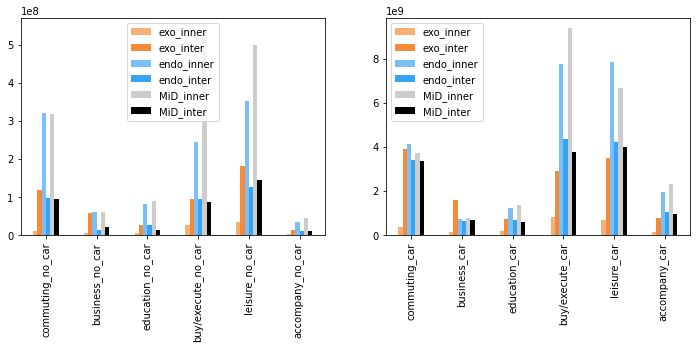

In [133]:
# Compare inner- and inter-zonal volumes by segment
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
seg_df.loc[[s for s in segments if '_no_car' in s]].plot.bar(
    legend=True, color=['#f7af78', '#f68a37', '#78c0f7', '#37a3f6', '#cccccc', '#000000'], ax=ax[0])
seg_df.loc[[s for s in segments if not '_no_car' in s]].plot.bar(
    legend=True, color=['#f7af78', '#f68a37', '#78c0f7', '#37a3f6', '#cccccc', '#000000'], ax=ax[1])

In [134]:
# Ratio of total endogenous volumes to scaled MiD volumes
(seg_df['endo_inner'] + seg_df['endo_inter']) / (seg_df['MiD_inner'] + seg_df['MiD_inter'])

commuting_no_car      1.013851
commuting_car         1.070403
business_no_car       0.939602
business_car          0.938085
education_no_car      1.031095
education_car         0.977319
buy/execute_no_car    0.539820
buy/execute_car       0.920482
leisure_no_car        0.742180
leisure_car           1.133230
accompany_no_car      0.828394
accompany_car         0.916798
dtype: float64

In [135]:
np.round(seg_df / 1e6, 1)

,exo_inner,exo_inter,endo_inner,endo_inter,MiD_inner,MiD_inter
commuting_no_car,12.0,118.9,320.1,97.8,318.2,93.9
commuting_car,392.3,3894.0,4150.9,3411.0,3700.3,3364.2
business_no_car,4.7,57.4,61.7,14.2,60.0,20.8
business_car,133.7,1606.6,751.4,624.8,783.1,684.0
education_no_car,6.6,25.6,82.0,26.2,90.4,14.5
education_car,183.1,710.9,1241.5,665.9,1368.3,583.3
buy/execute_no_car,27.1,95.4,245.4,94.6,543.2,86.8
buy/execute_car,824.0,2901.5,7755.7,4364.1,9378.0,3788.8
leisure_no_car,35.7,182.6,352.0,125.7,499.7,143.9
leisure_car,682.8,3511.3,7856.0,4205.6,6657.2,3986.3


In [136]:
# Share of inner-zonal trips in endogenous volumes
np.round(seg_df['endo_inner'] / (seg_df['endo_inter'] + seg_df['endo_inner']), 3)

commuting_no_car      0.766
commuting_car         0.549
business_no_car       0.813
business_car          0.546
education_no_car      0.758
education_car         0.651
buy/execute_no_car    0.722
buy/execute_car       0.640
leisure_no_car        0.737
leisure_car           0.651
accompany_no_car      0.741
accompany_car         0.647
dtype: float64

### Distance distribution

In [25]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 300, 500, 1000]
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [137]:
# Assign distances to volumes
for df in [new.volumes, sm.volumes, vp2017, mid2017]:#, cc]:
    if not 'bins' in df.columns:
        df['dist'] = df.set_index(['origin', 'destination']).index.map(distances.to_dict()['length'])
        df['bins'] = pd.cut(df['dist'], bins=bins, labels=labels)

<AxesSubplot:xlabel='bins'>

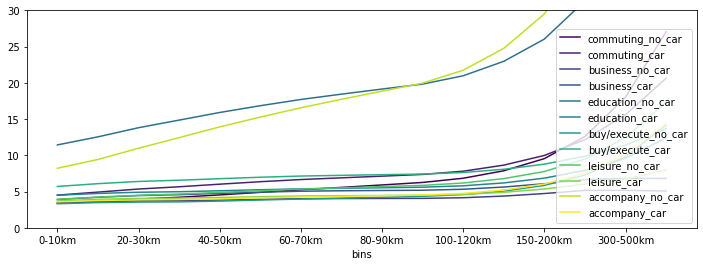

In [24]:
# Look at the CC over distance by segment (builds the deterrence matrix)
#cc.loc[cc.notna().all(axis=1)].groupby('bins')[segments].mean().plot.line(
#    legend=True, figsize=(12,4), colormap='viridis', ylim=(0,30))

In [25]:
# Look at the deterrence as fed to the distribution function (roughly)
#np.power(cc.loc[cc.notna().all(axis=1)].groupby('bins')[segments].mean(), -10).plot.line(
#    legend=True, figsize=(12,4), colormap='viridis')

In [138]:
# Sum up volumes of the model and VP2030
vol_df = pd.DataFrame()
for car in car_segment_dict.values():
    segs = [s for s in segments if s.endswith(car)]
    vol_df['endo'+car] = new.volumes.groupby('bins').sum()[segs].sum(axis=1)
    vol_df['exo'+car] = sm.volumes.groupby('bins').sum()[segs].sum(axis=1)
vol_df['endo'] = new.volumes.groupby('bins').sum()[segments].sum(axis=1)
vol_df['exo'] = sm.volumes.groupby('bins').sum()[segments].sum(axis=1)

<AxesSubplot:xlabel='bins'>

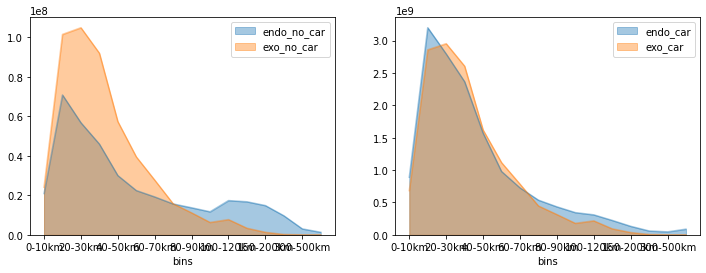

In [139]:
# plot
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
vol_df[['endo_no_car', 'exo_no_car']].plot(kind='area', stacked=False, alpha=.4, ax=ax[0])
vol_df[['endo_car', 'exo_car']].plot(kind='area', stacked=False, alpha=.4, ax=ax[1])

<AxesSubplot:xlabel='bins'>

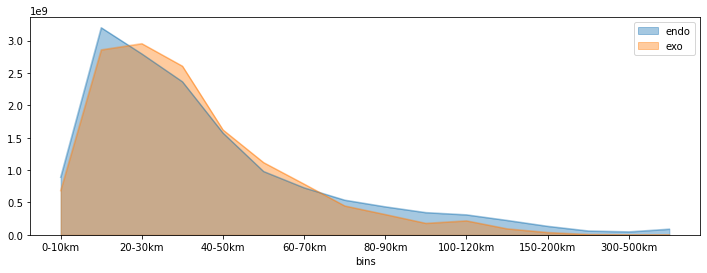

In [140]:
# plot total
vol_df[['endo', 'exo']].plot(kind='area', stacked=False, alpha=.4, figsize=(12,4))

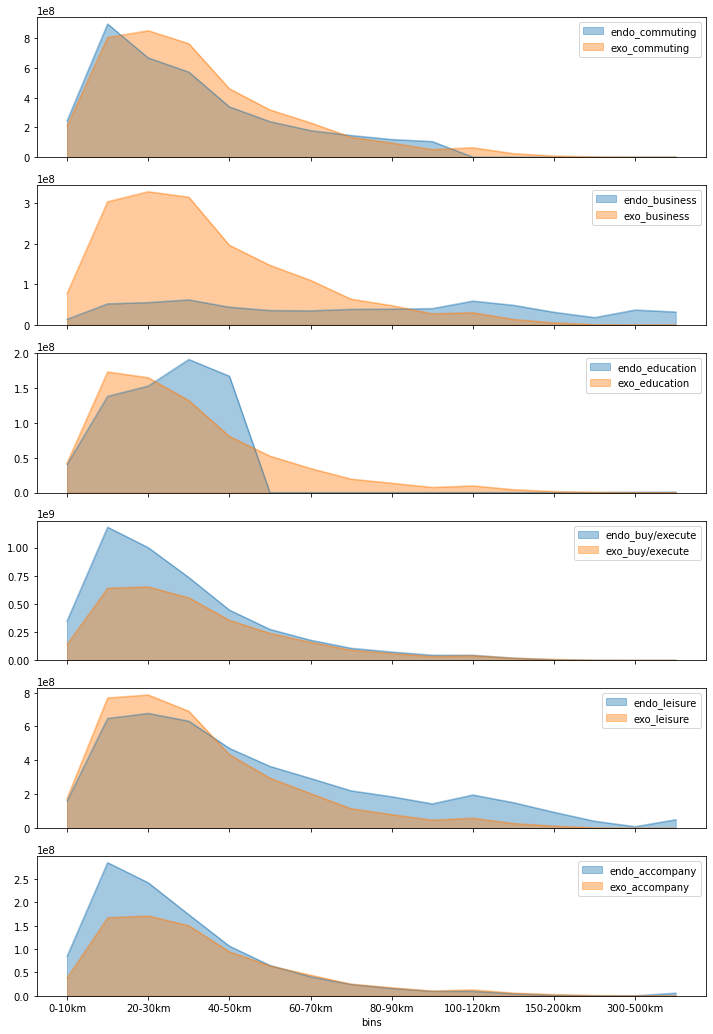

In [141]:
# plot by purpose
fig, ax = plt.subplots(ncols=1, nrows=len(purposes), figsize=(12,len(purposes)*3), sharex='all')
i = 0
for p in purposes:
    vol_df['endo_'+p] = new.volumes.groupby('bins').sum()[[s for s in segments if p in s]].sum(axis=1)
    vol_df['exo_'+p] = sm.volumes.groupby('bins').sum()[[s for s in segments if p in s]].sum(axis=1)
    vol_df[['endo_'+p, 'exo_'+p]].plot(kind='area', stacked=False, alpha=.4, ax=ax[i])
    i += 1

In [142]:
# Scale to VP2030 levels
vol_df['VP2030'] = vp2017.loc[vp2017['bins'].notna()].groupby('bins').sum()[
    ['commuting', 'education', 'buy/execute', 'business', 'leisure']
].sum(axis=1)
vol_df['endo'] /= vol_df['endo'].mean() / vol_df['VP2030'].mean()
vol_df['exo'] /= vol_df['exo'].mean() / vol_df['VP2030'].mean()

<AxesSubplot:xlabel='bins'>

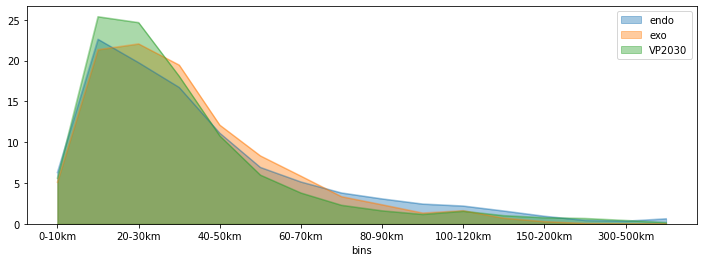

In [143]:
# plot with VP2030
vol_df[[c for c in vol_df.columns if not '_' in c]].plot(
    kind='area', stacked=False, alpha=.4, figsize=(12,4))

In [144]:
# Add MiD2017
vol_df['MiD2017'] = mid2017.loc[(mid2017['bins'].notna())
                                & (mid2017['origin']!=mid2017['destination'])
                               ].groupby('bins').size()
vol_df['MiD2017'] /= vol_df['MiD2017'].mean() / vol_df['VP2030'].mean()

<AxesSubplot:xlabel='bins'>

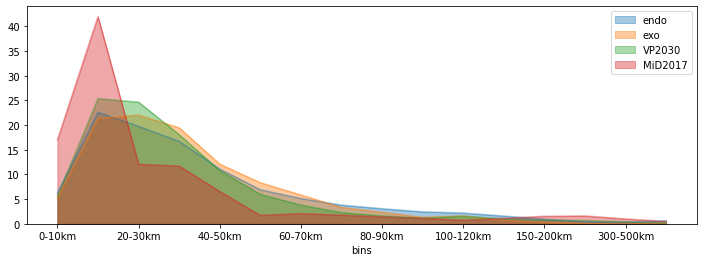

In [145]:
# plot with VP2030
vol_df[[c for c in vol_df.columns if not '_' in c]].plot(
    kind='area', stacked=False, alpha=.4, figsize=(12,4))